#  In this project we want to estimate an output based on more than 300 parameters.  Predicting consumption using part build and performance parameters is the goal here. Finding the most effective parameters on consumption is the second goal in this project

Pre-processing and data cleaning should be applied on more than 300 predictors of the consumption. Then, we model the data with different machine learning algorithms and select the best method that gives us minimum MSE. 

#### Author: Pantea Tavakolian ####

In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt

**Here, we get two dataset from two excel sheets. The first excel sheet has the input variables(df1), and the second sheet (df2) contains the target, and a few input variables**

We can find the serial number of the parts in the first column of both excel files.

In [2]:
# The code was removed by Watson Studio for sharing.

--2020-03-17 18:04:59--  https://www.dropbox.com/s/y6bxfle6qh4wnpo/Consolidated%20Build%20Parameters%20V2.xlsx?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/y6bxfle6qh4wnpo/Consolidated%20Build%20Parameters%20V2.xlsx [following]
--2020-03-17 18:04:59--  https://www.dropbox.com/s/raw/y6bxfle6qh4wnpo/Consolidated%20Build%20Parameters%20V2.xlsx
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc343c5e34db5ce3e42bb00abf9.dl.dropboxusercontent.com/cd/0/inline/A0F-sr8PBwZRu3SAJfsqbKpt85u-a8Edpf9aL3cD91BHAlBfFnvQVxRXyjZD_9to3sqNrgi45OvXdGVxn4oyN0vWveM7Avu6MbTMn5SE-3Ht-0T_TLA7yYSRUNl9_yRaGNc/file# [following]
--2020-03-17 18:04:59--  https://ucc343c5e34db5ce3e42bb00abf9.dl.dropboxusercontent.com/cd/0/inline/A0F-sr8PBwZRu3SA

In [3]:
# The first 
df1=pd.read_excel('Consolidated_Build_Parameters_V2.xlsx')
df2=pd.read_excel('Production_Database_Output.xlsx')

### For cleaning, the  first row on sheet 1 is removed. It does not include any useful data

In [4]:
# for cleaning, the  first row is removed. It does not include any useful data
df1=df1.drop([0])
df1=df1.reset_index(drop=True)
# We also remove the first column of df2
df2=df2.drop(columns=['Unnamed: 0'])

### The serial numbers do not match. The output is not recorded for all the parts. Therefore, we need to match the first columns of the two sheets.

The first column of both files have the serial numbers of the parts. First sheet contains information of more parts than the second sheet. Here, first we want to match them based on the serial/engine numbers

**Since the serial numbers contain 'CN' followed by an integer value, we first remove the 'CN' charachter.**

In [5]:
Engine_name1=df1.iloc[:,0]
Engine_name2=df2.iloc[:,0]

In [6]:
for i in range(len(Engine_name2)):
    Engine_name2[i]=int(str(Engine_name2[i]).replace("CN",""))
for i in range(len(Engine_name1)):    
    Engine_name1.iloc[i]=int(str(Engine_name1.iloc[i]).replace("CN",""))#for i in range(len(Engine_name2[0])):

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


### Now, we have an integer value for each engine recorded in Engine_name2 and Engine_name1.

The indexing in sheet 1 and 2 can be changed to the engine serial number

In [7]:
df2.index=df2.iloc[:,0]
df1.index=df1.iloc[:,0]
#df1['SN_SLAVE_EEC'].tail()

Second, we see the number of engines that the output result are recorded for (in Engine_name2/ df2.iloc[:, 0])  are smaller than the number of engine parameters that are recorded in sheet 1. Therefore, the rows (engine number) in sheet #2 are selected as the reference. 



**Here we want to merge the needed columns of data frame sheet #2 to data frame sheet #1. Since the output is in sheet #2,We select that sheet as the reference.**
Looking at the tails of data frames, we see the matching is done correctly



In [8]:
df = pd.concat([df2, df1], axis=1).reindex(df2.index)
#print(df.columns)
print(np.shape(df))
#df.iloc[1, 350:352].head
#df.tail()

(481, 325)


Now, we have 325 - 1 ('SFC') = 324 parameters and 481 engines that are going to predict the output ('SFC'). The output is also in this sheet.

**Cal_DATE has information on timing the data are captured. It is a time stamp. The next two cells convert the time into integer values**

In [9]:
import datetime as dt
import time
from datetime import timedelta as td

def to_integer(dt_time):
    return 10000000000*dt_time.dt.year + 100000000*dt_time.dt.month + 1000000*dt_time.dt.day+10000*dt_time.dt.hour+100*dt_time.dt.minute+dt_time.dt.second

In [10]:
df['CAL_DATE']=pd.to_datetime(df['CAL_DATE'])
dt_time=df['CAL_DATE']
df['CAL_DATE']=to_integer(dt_time)
# we can normalize the value as it is too large
df['CAL_DATE']=df['CAL_DATE']/np.mean(df['CAL_DATE'])
df.head()

,SN,WFE,Consumption,CAL_DATE,Test-loc,FNCOR,T_AMB,LHV,SN_BM,SN_TRANS_DUCT,...,HPT2 COVER LOW SPOT RADIAL RUNOUT,"INITIAL GAP Z"" AT ""0"" DEG""","INITIAL GAP Z"" AT ""120"" DEG""","INITIAL GAP Z"" AT ""240"" DEG""",LP SHAFT SETTING DIMENSION,LP SHAFT SPACER SETTING,MAXIMUM FAN SPACER THICKNESS,REQUIRED AGB SPACER THICKNESS,VALIDATE BACKLASH,"VALIDATE DIMENSION Y"""""
SN,,,,,,,,,,,,,,,,,,,,,
1,1,2439.836914,0.411755,0.998358,2204.0,1.014,60.119228,18505.0,FV560,FV231,...,0,0.039,0.041,0.041,2.7725,0.1329,0.205,0.056,0.0002808,-0.0003
2,2,2461.390137,0.415255,0.998359,2204.0,1.014,72.873077,18505.0,FV560,GK321,...,0,0.047,0.047,0.047,2.7732,0.1371,0.20205,0.052,0.0005994,0.0005
3,3,2437.280762,0.412241,0.998378,2204.0,1.014,25.419010,18494.0,FV560,FV231,...,0,0.046,0.038,0.045,2.7713,0.13835,0.2033,0.054,0.0007704,-0.0007
4,4,2432.734375,0.411309,0.998382,2203.0,1.018,36.020229,18494.0,FV561,FV231,...,0,0.04,0.041,0.039,2.771,0.1395,0.2,0.0556,0.0011098,0.0005
5,5,2431.837158,0.411445,0.998824,2204.0,1.014,17.635309,18502.0,FV560,GK322,...,0,0.04,0.04,0.041,2.77115,0.1331,0.2118,0.0593,0.0012296,-0.0004


#### Seven columns (SN_BM, SN_TRANS_DUCT, and 'SN_EX_NOZ_5, 'SN_SLAVE_EEC', 'ENGINE_MOUNT','DIMENSION Y""','DIMENSION X""') which have string values are converted to integer values by the following three cells

In [11]:
for i in Engine_name2:
    try:
        df['SN_BM'][i]=df['SN_BM'][i].replace("FV","").replace("AJ","").replace("SN","").replace("GJ","").replace("AG","")
        df['SN_BM'][i]=int(df['SN_BM'][i])
        df['SN_TRANS_DUCT'][i]=df['SN_TRANS_DUCT'][i].replace("FV","").replace("GK","").replace("AJ","").replace("GC","").replace("AG","")
        df['SN_TRANS_DUCT'][i]=int(df['SN_TRANS_DUCT'][i])

    except:
        pass

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWar

In [12]:
for i in Engine_name2:
    try:
        df['SN_EX_NOZ_5'][i]=df['SN_EX_NOZ_5'][i].replace("FV","").replace("ME","").replace("GB","")
        df['SN_EX_NOZ_5'][i]=int(df['SN_EX_NOZ_5'][i])
        df['SN_SLAVE_EEC'][i]=df['SN_SLAVE_EEC'][i].replace("AF","").replace("AG","").replace("A","")#.replace("GJ","").replace("AG","")
        df['SN_SLAVE_EEC'][i]=int(df['SN_SLAVE_EEC'][i])

    except:
        pass

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWar

In [13]:
for i in Engine_name2:
    try:
        df['ENGINE_MOUNT'][i]=df['ENGINE_MOUNT'][i].replace("KIT","").replace("KT","").replace("#","").replace("_","").replace("-","").replace("LK","").replace("/","")
        df['ENGINE_MOUNT'][i]=int(df['ENGINE_MOUNT'][i])
        df['DIMENSION X""'][i]=df['DIMENSION X""'][i].replace("SKIP","0.1")
        df['DIMENSION X""'][i]=float(df['DIMENSION X""'][i])
        df['DIMENSION Y""'][i]=df['DIMENSION Y""'][i].replace("SKIP","0.1")
        df['DIMENSION Y""'][i]=float(df['DIMENSION Y""'][i])

    except:
        pass

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWar

In [16]:
import statistics as stat
import numpy as np
# df['SN_BM']=df['SN_BM'].fillna(stat.mode(df['SN_BM']))
# df['SN_TRANS_DUCT']=df['SN_TRANS_DUCT'].fillna(stat.mode(df['SN_TRANS_DUCT']))
# df['SN_EX_NOZ_5']=df['SN_EX_NOZ_5'].fillna(stat.mode(df['SN_EX_NOZ_5']))
# df['SN_SLAVE_EEC']=df['SN_SLAVE_EEC'].fillna(stat.mode(df['SN_SLAVE_EEC']))
# df['ENGINE_MOUNT']=df['ENGINE_MOUNT'].fillna(stat.mode(df['ENGINE_MOUNT']))
# df['DIMENSION X""']=df['DIMENSION X""'].fillna((np.mean(df['DIMENSION X""'])))
# df['DIMENSION Y""']=df['DIMENSION Y""'].fillna(np.mean(df['DIMENSION Y""']))

**Some columns are removed. SN column is also removed, because we have already changed the indexing to serial numbers**

In [19]:
print(np.shape(df))
df=df.drop(columns=['ACCEPT_SUF', 'CALCULATE TAPER (A1 - C1)', 'SN', '(B1) RECORD DIAMETER','(B1) VERIFY FINAL DIAMETER'])
df=df.drop(columns=['(B1) VERIFY FINALX" OFFSET"', '(B1) VERIFY FINALY" OFFSET"', 'TDC SUPPORT', 'Engine'])
df=df.drop(columns=['TDC SUPPORT (REP)','TDC SEAL', 'QUANTITY OF SPACER(S) TO BE GROUND','COMBUSTOR RUNOUT AT POSITION A""'])
print(np.shape(df))

(481, 312)


### All the 'Nan's are filled with  mean or mode of each column


In [20]:
k=0
j=0
for i in range(len(df.columns)):
    try:
        filler=(stat.mode(df.iloc[:,i]))
        k=k+1
        dfnonan=df.fillna(filler)

    except:
        filler=(np.mean(df.iloc[:,i]))
        j=j+1
        df_no_nan=df.fillna(filler)
#dfnonan=df10.fillna(0)

# Now that the cleaning is done, we convert the data into target and predictor categories
### We should now limit our parameters by finding the most effective ones

Number of Parts:  481


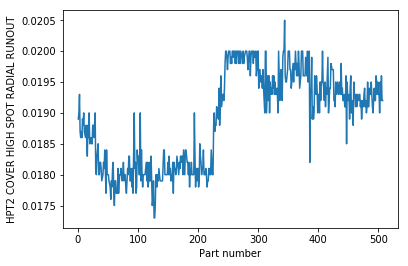

In [21]:
target= df['Consumption']
predictors=df_no_nan

## ploting one data
plt.plot(predictors.iloc[:,100])
plt.xlabel('Part number')
plt.ylabel(predictors.columns[300])
print('Number of Parts: ',np.size(df.iloc[:,1]))

In [22]:
print('number of columns (input parameters) that is going to estimate the target is:',len(predictors.columns))

number of columns (input parameters) that is going to estimate the target is: 312


# Here, I am limiting the 312 parameters by running cross-correlation. I will keep the parameters that has a correlation with our targer, and ignore the rest.

**Here a corr variable is defined with values of 1.01 and length of the number of predictors. Then, the parameters that have correlation with the target will change the values of corr from 1.01 to the cross-correlation values. Knowing that the cross-correlation result will become a value between -1 to 1, we can remove the cross-correlation values of 1.01. This way, the parameters that has no cross-correlation with the target will be removed.** 

**We keep the title of the parameters in title_rec** 

Text(0, 0.5, 'Cross-correlation value of the Independent Variable with the target')

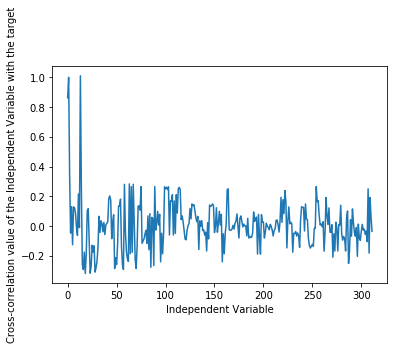

In [23]:
# finding the correlation of all the columns with the target (SFC). 

from scipy.stats import pearsonr
# calculate Pearson's correlation
corr=np.zeros(len(predictors.columns))+1.01 # 1.01 is added for this version to remove some columns. 
                                            # The cross-correlation values are between -1 to 1.
title_record=[]
for i in range(len(predictors.columns)):
    try:
        corr[i],_ = pearsonr(predictors.iloc[:,i], target)
        title_record. append(predictors.columns[i]) 
    except:
        pass
plt.plot(corr)
plt.xlabel('Independent Variable')
plt.ylabel('Cross-correlation value of the Independent Variable with the target')


#corr

In [24]:
print(np.shape(title_record))
#title_rec[300:323]

(311,)


### In this cell we remove the corr values of 1.01 and we save the rest in a new defined variable of cor

**We can also remove correlation values of less than 0.1 as they are ineffective in predicting the target. The titles of these parameters are recorded in title_rec_new**

Number of corr equal to 1.01 is: 1
Only variable ACCEPT_SUF has string value (all PRD) which gives correlation of 1.01.


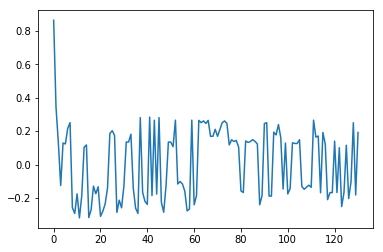

In [25]:
# removing all the unwanted columns (that hava no correlation with the target) and correlation values 
cor=[]
title_rec_new=[]
j=0
for i in range(len(corr)):
    if corr[i]<1 and np.abs(corr[i])>0.1:
        cor.append(corr[i])
        title_rec_new.append(predictors.columns[i])
    if(corr[i]==1.01):
        j=j+1

plt.plot(cor)
print('Number of corr equal to 1.01 is:', j)
print('Only variable ACCEPT_SUF has string value (all PRD) which gives correlation of 1.01.')

### The input varibles (independent x variables) is defined here

In [26]:
x=predictors[title_rec_new]
print('the number of parameters that are used to predict the target',len(x.columns))
#print('Title of the parameters that are used to predict the target',(title_rec_new))
print('number of columns (input parameters) after cross-correlation is:',len(x.columns))

the number of parameters that are used to predict the target 131
number of columns (input parameters) after cross-correlation is: 131


In [27]:
print(np.shape(x))

(481, 131)


## Now, we perform train test split
We want to run Random Forest to find the effective parameters first. Then, we model the data with different machine learning algorithm


In [28]:
msk = np.random.rand(len(target)) < 0.8
x_train = x[msk]
x_test = x[~msk]
y_train = target[msk]
y_test = target[~msk]

train_x = np.asanyarray(x_train)
train_y = np.asanyarray(y_train)

test_x = np.asanyarray(x_test)
test_y = np.asanyarray(y_test)

In [29]:
#with preprocessing x = StandardScaler().fit_transform(df)
from sklearn.preprocessing import StandardScaler

train_x = StandardScaler().fit_transform(x_train)
test_x=StandardScaler().fit_transform(x_test)

In [30]:
from sklearn.ensemble import RandomForestRegressor
forest= RandomForestRegressor(n_estimators=1200, criterion='mae', random_state=0)
forest.fit(train_x,train_y)
y_hat_rf=forest.predict(test_x)

In [31]:
from sklearn.metrics import r2_score


print("Mean absolute error: %.10f" % np.mean(np.absolute(y_hat_rf- test_y)))
print("Residual sum of squares (MSE): %.10f" % np.mean((y_hat_rf - test_y) ** 2))
print("R2-score: %.5f" % r2_score(test_y, y_hat_rf) )

Mean absolute error: 0.0002860398
Residual sum of squares (MSE): 0.0000001298
R2-score: 0.91075


## The following cell finds important feautures. I am limiting the important parameters to 5 

In [32]:
names=x.columns[0:5]
get_feature_importance=sorted(zip(map(lambda x: round(x, 4), forest.feature_importances_), names), reverse=True)
print("Features sorted by their score:", get_feature_importance)

get_important_variables=[]
for i in range(len(get_feature_importance)):
    get_important_variables.append(get_feature_importance[i][1])

print(np.shape(get_important_variables))
type(get_important_variables)

Features sorted by their score: [(0.5855, 'WFE'), (0.1643, 'T_AMB'), (0.0051, 'LHV'), (0.0024, 'CAL_DATE'), (0.0004, 'FNCOR')]
(5,)


list

# The most effective variables can be kept in a new predictor variable

In [57]:
predictors_new=x[get_important_variables]

## The following cell plots the dependent target (Consumption) as a function of the most effective independent predictors (predictors_new)


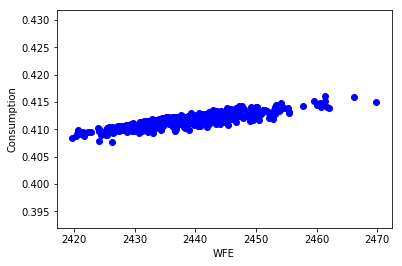

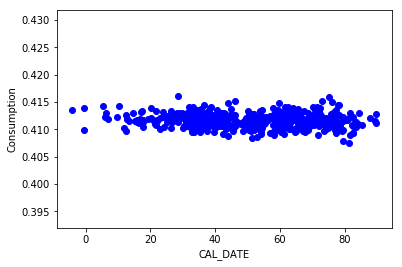

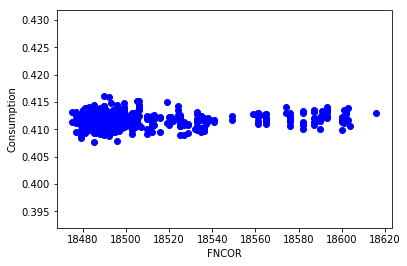

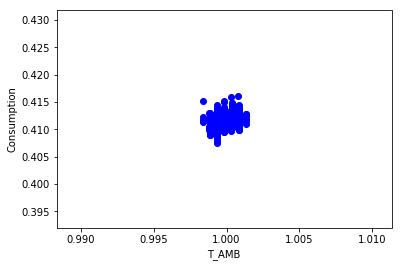

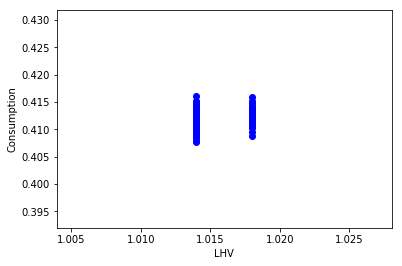

In [58]:
# Import time for sleep
import time
i=0
while (i<len(predictors_new.iloc[1,:])):
    try:
        plt.scatter(predictors_new.iloc[:,i], target, color='blue')
        plt.ylabel('Consumption')
        plt.xlabel(title_rec_new[i])
        plt.show()
    except:
        pass
    #time.sleep(1)
    i=i+1

## Now, we perform train test split again on the most effective predictors and the target to find the best model to predict the consumption

In [59]:
predictors_new.shape

(481, 5)

In [71]:
#msk = np.random.rand(len(target)) < 0.8
x_train = predictors_new[msk]
x_test = predictors_new[~msk]
y_train = target[msk]
y_test = target[~msk]

train_x = np.asanyarray(x_train)
train_y = np.asanyarray(y_train)

test_x = np.asanyarray(x_test)
test_y = np.asanyarray(y_test)

# 1- Linear regression

Linear regression gives us the best result when we only perform it on a few variables. 

They are achieved by first keeping the variables with absolute cross-correlation values of more than 0.1 with the target. Second, finding effective variables with running random forest. 

In [72]:
from sklearn import linear_model

regr = linear_model.LinearRegression()

regr.fit (train_x , train_y)
# The coefficients
print ('Coefficients: ', regr.coef_)
print(regr.intercept_)

Coefficients:  [ 1.52621177e-04 -3.06127622e-05 -7.84055988e-07  4.77034256e-02
  3.79035624e-02]
-0.030604294409480204


In [73]:
from sklearn.metrics import r2_score

y_hat_lr=regr.predict(test_x)
# Explained variance score: 1 is perfect prediction
print("Mean absolute error: %.10f" % np.mean(np.absolute(y_hat_lr - test_y)))
print("Residual sum of squares (MSE): %.10f" % np.mean((y_hat_lr- test_y) ** 2))
print("R2-score: %.5f" % r2_score( test_y, y_hat_lr))

Mean absolute error: 0.0002268221
Residual sum of squares (MSE): 0.0000000898
R2-score: 0.93823


Text(0.5, 0, 'part #')

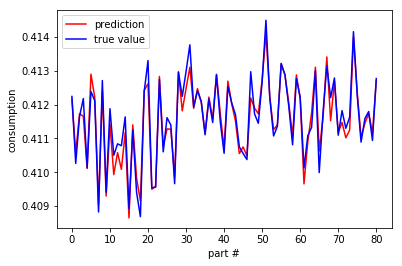

In [74]:
plt.plot(y_hat_lr ,color='red', label='prediction')
plt.plot(test_y ,color='blue',label='true value')
plt.legend(loc='upper left',fontsize=10)
plt.ylabel('consumption')
plt.xlabel('part #')



# 2. Decision Tree Regression

This model needs preprocessing

This model was not good. Also, polynomial regression never gave a good result specially for degrees of more than 1.

Therefore, the polynomial regression is removed 

In [75]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
train_x = StandardScaler().fit_transform(x_train)
test_x=StandardScaler().fit_transform(x_test)

In [76]:
from sklearn.tree import DecisionTreeRegressor
dt=DecisionTreeRegressor(random_state=0)
dt=dt.fit(train_x, y_train.values.ravel())
y_hat_dt=dt.predict(test_x)

In [77]:
from sklearn.metrics import r2_score

print("Mean absolute error: %.10f" % np.mean(np.absolute(y_hat_dt - test_y)))
print("Residual sum of squares (MSE): %.10f" % np.mean((y_hat_dt - test_y) ** 2))
print("R2-score: %.5f" % r2_score(y_hat_dt , test_y) )

Mean absolute error: 0.0003718493
Residual sum of squares (MSE): 0.0000002056
R2-score: 0.87299


Text(0.5, 0, 'part #')

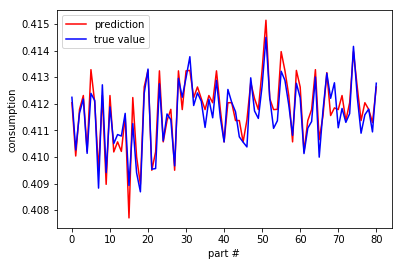

In [78]:
plt.plot(y_hat_dt,color='red', label='prediction')
plt.plot(test_y ,color='blue', label='true value')
plt.legend(loc='upper left',fontsize=10)
plt.ylabel('consumption')
plt.xlabel('part #')

# 3. Random Forest Regression


In [79]:
from sklearn.ensemble import RandomForestRegressor
forest= RandomForestRegressor(n_estimators=3050, criterion='mae', random_state=0)
forest.fit(train_x,train_y)
y_hat_rf=forest.predict(test_x)
test_y=np.asanyarray(y_test)

In [80]:
from sklearn.metrics import r2_score


print("Mean absolute error: %.10f" % np.mean(np.absolute(y_hat_rf- test_y)))
print("Residual sum of squares (MSE): %.10f" % np.mean((y_hat_rf - test_y) ** 2))
print("R2-score: %.5f" % r2_score(test_y, y_hat_rf) )

Mean absolute error: 0.0002902209
Residual sum of squares (MSE): 0.0000001246
R2-score: 0.91430


Text(0.5, 0, 'part #')

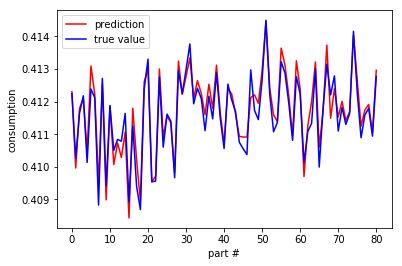

In [81]:
plt.plot(y_hat_rf,color='red', label='prediction')
plt.plot(test_y,color='blue', label='true value')
plt.legend(loc='upper left',fontsize=10)
plt.ylabel('consumption')
plt.xlabel('part #')

# The effective parameters are :
WFE, T_AMP, LHV, CAL_DATE, FNCOR

The best way to predict consumption are linear regression and Random Forest regression

Mean absolute error: 0.0002268221

Residual sum of squares (MSE): 0.0000000898

R2-score: 0.93823